In [1]:
# IMPORT LIBRARIES
import mxnet
from mxnet import nd, autograd
print("MXNet version", mxnet.__version__) # Matteo 1.5.1

# Fixing the random seed
mxnet.random.seed(0)

MXNet version 1.5.1


In [2]:
# IMPORT LIBRARIES FOR TRAIN A NETWORK
from mxnet import nd, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import datasets, transforms
from IPython import display
import matplotlib.pyplot as plt
import time

In [3]:
# SETUP THE PROFILING
from mxnet import profiler

profiler.set_config(profile_all=True,
                    aggregate_stats=True,
                    continuous_dump=True,
                    filename='profile_output_gluon.json')

## Working - From Official Documentation
https://mxnet.apache.org/api/python/docs/tutorials/packages/gluon/image/mnist.html

In [4]:
# GET DATASET AND SPLIT
mnist = mxnet.test_utils.get_mnist()
batch_size = 200
train_data = mxnet.io.NDArrayIter(mnist['train_data'], mnist['train_label'], batch_size, shuffle=True)
val_data = mxnet.io.NDArrayIter(mnist['test_data'], mnist['test_label'], batch_size)

In [5]:
# DEFINE THE NETWORK
handwritten_net = nn.Sequential()
handwritten_net.add(nn.Conv2D(channels=6, kernel_size=5, activation='relu'),
        nn.AvgPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=3, activation='relu'),
        nn.AvgPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(120, activation="relu"),
        nn.Dense(84, activation="relu"),
        nn.Dense(10))
# 2D convolution layer (e.g. spatial convolution over images).
'''
mxnet.gluon.nn.Conv2D(channels, kernel_size, activation=None, etc)
channels (int) – 
    The dimensionality of the output space, 
    i.e. the number of output channels (filters) 
    in the convolution.
kernel_size (int or tuple/list of 2 int) – 
    Specifies the dimensions of the convolution window.
activation (str) – 
    Activation function to use. 
    See mxnet.ndarray.Activation
    If you don’t specify anything, 
    no activation is applied (ie. “linear” activation: a(x) = x).
'''

# Max pooling operation for two dimensional (spatial) data.
'''
mxnet.gluon.nn.MaxPool2D(pool_size=(2, 2), strides=None, etc)
pool_size (int or list/tuple of 2 ints,) – 
    Size of the max pooling windows.
strides (int, list/tuple of 2 ints, or None.) – 
    Factor by which to downscale. 
    E.g. 2 will halve the input size. 
    If None, it will default to pool_size.
'''

# Flattens the input to two dimensional.
'''
mxnet.gluon.nn.Flatten (no params)
data: input tensor with arbitrary shape (N, x1, x2, …, xn)
out: 2D tensor with shape: (N, x1 cdot x2 cdot … cdot xn)
'''


'\nmxnet.gluon.nn.Flatten (no params)\ndata: input tensor with arbitrary shape (N, x1, x2, …, xn)\nout: 2D tensor with shape: (N, x1 cdot x2 cdot … cdot xn)\n'

Various ways for training in Gluon
https://mxnet.apache.org/api/python/docs/tutorials/packages/gluon/training/index.html

In [6]:
# TRAIN THE NETWORK WITH ACCURACY
epoch = 15
# CHECK IF GPUS ARE PRESENT
gpus = mxnet.test_utils.list_gpus()
ctx =  [mxnet.gpu()] if gpus else [mxnet.cpu(0), mxnet.cpu(1)]
handwritten_net.initialize(mxnet.init.Xavier(), ctx=ctx, force_reinit=True)
trainer = gluon.Trainer(handwritten_net.collect_params(), 'sgd', {'learning_rate': 0.02})
# Use Accuracy as the evaluation metric.
metric = mxnet.metric.Accuracy()
softmax_cross_entropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()

'''
# Ask the profiler to start recording
profiler.set_state('run')
'''

for i in range(epoch):
    # Reset the train data iterator.
    train_data.reset()
    # Loop over the train data iterator.
    for batch in train_data:
        # Splits train data into multiple slices along batch_axis
        # and copy each slice into a context.
        data = gluon.utils.split_and_load(batch.data[0], ctx_list=ctx, batch_axis=0)
        # Splits train labels into multiple slices along batch_axis
        # and copy each slice into a context.
        label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
        outputs = []
        # Inside training scope
        with autograd.record():
            for x, y in zip(data, label):
                z = handwritten_net(x)
                # Computes softmax cross entropy loss.
                loss = softmax_cross_entropy_loss(z, y)
                # Backpropogate the error for one iteration.
                loss.backward()
                outputs.append(z)
        # Updates internal evaluation
        metric.update(label, outputs)
        # Make one step of parameter update. Trainer needs to know the
        # batch size of data to normalize the gradient by 1/batch_size.
        trainer.step(batch.data[0].shape[0])
    # Gets the evaluation result.
    name, acc = metric.get()
    # Reset evaluation result to initial state.
    metric.reset()
    print('training acc at epoch %d: %s=%f'%(i, name, acc))
'''
# Make sure all operations have completed
mxnet.nd.waitall()
# Ask the profiler to stop recording
profiler.set_state('stop')
# Dump all results to log file before download
profiler.dump()  
'''

training acc at epoch 0: accuracy=0.553133
training acc at epoch 1: accuracy=0.883817
training acc at epoch 2: accuracy=0.912917
training acc at epoch 3: accuracy=0.927500
training acc at epoch 4: accuracy=0.937967
training acc at epoch 5: accuracy=0.944550
training acc at epoch 6: accuracy=0.949750
training acc at epoch 7: accuracy=0.954333
training acc at epoch 8: accuracy=0.956900
training acc at epoch 9: accuracy=0.960633
training acc at epoch 10: accuracy=0.963350
training acc at epoch 11: accuracy=0.965267
training acc at epoch 12: accuracy=0.967050
training acc at epoch 13: accuracy=0.968633
training acc at epoch 14: accuracy=0.970317


"\n# Make sure all operations have completed\nmxnet.nd.waitall()\n# Ask the profiler to stop recording\nprofiler.set_state('stop')\n# Dump all results to log file before download\nprofiler.dump()  \n"

In [7]:
# TEST THE NETWORK
metric = mxnet.metric.Accuracy()
# Reset the validation data iterator.
val_data.reset()
# Loop over the validation data iterator.
for batch in val_data:
    # Splits validation data into multiple slices along batch_axis
    # and copy each slice into a context.
    data = gluon.utils.split_and_load(batch.data[0], ctx_list=ctx, batch_axis=0)
    # Splits validation label into multiple slices along batch_axis
    # and copy each slice into a context.
    label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
    outputs = []
    for x in data:
        outputs.append(handwritten_net(x))
    # Updates internal evaluation
    metric.update(label, outputs)
print('validation acc: %s=%f'%metric.get())
assert metric.get()[1] > 0.90

validation acc: accuracy=0.970400


## Adaptation from Fashion MNIST tutorial - Problem with input shape

In [8]:
# GET THE TRAIN SET - HANDWRITTEN DIGITS
# Apply a transformation to the dataset, normalize data from (0,255) -> (0,1)
handwritten_train = datasets.MNIST(train=True, transform=lambda data, label: (data.astype(dtype='float32')/255, label))
print("Nr samples: ", len(handwritten_train))
X, y = handwritten_train[0]
print('X shape: ', X.shape, 'X dtype', X.dtype, 'y shape:', y.shape)
print( "1 DATAPOINT consists in: 28 x 28 images - 10 outputs")

Nr samples:  60000
X shape:  (28, 28, 1) X dtype <class 'numpy.float32'> y shape: ()
1 DATAPOINT consists in: 28 x 28 images - 10 outputs


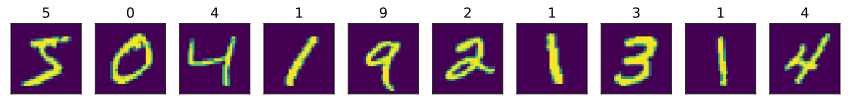

In [9]:
# VISUALIZE THE FIRST 10 DATAPOINTS
# ONE FOR EACH LABEL

text_labels = ['0', '1', '2', '3', '4',
               '5', '6', '7', '8', '9']
X, y = handwritten_train[0:10]
# plot images
display.set_matplotlib_formats('svg')
# CREATE 10 FUGURES (X.shape[0] = 10)
_, figs = plt.subplots(1, X.shape[0], figsize=(15, 15))
# TAKING THE FIG OBJECT WE CAN MODIFY EVERYTHING
for f,x,yi in zip(figs, X,y):
    # 3D->2D by removing the last channel dim
    f.imshow(x.reshape((28,28)).asnumpy())
    ax = f.axes
    ax.set_title(text_labels[int(yi)])
    ax.title.set_fontsize(14)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [10]:
'''
# CONVERT IMAGES FOR THE GLUON MODEL 
# IMAGES -> (channel, height, width)
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])
# 0.13 = real mean of the column
# 0.31 = standard deviation
fashion_train = fashion_train.transform_first(transformer)
# JUST CREATED A LAZY TRANSFORMATION ... READY TO START
print(fashion_train)
'''

'\n# CONVERT IMAGES FOR THE GLUON MODEL \n# IMAGES -> (channel, height, width)\ntransformer = transforms.Compose([\n    transforms.ToTensor(),\n    transforms.Normalize(0.13, 0.31)])\n# 0.13 = real mean of the column\n# 0.31 = standard deviation\nfashion_train = fashion_train.transform_first(transformer)\n# JUST CREATED A LAZY TRANSFORMATION ... READY TO START\nprint(fashion_train)\n'

In [11]:
# SELCT A BATCH SIZE (FOR GRADIENT COMPUTATION)
batch_size = 1
# PRODUCE A DATALOADER TO LOAD DATA
# FEED THE DATASET (OR ITS LAZY TRANSFORMER)
'''
DataLoader
Loads data from a dataset and returns mini-batches of data
dataset : Dataset
    Source dataset. Note that numpy and mxnet arrays can be directly used
    as a Dataset.
shuffle : bool
        Whether to shuffle the samples.
batch_size : int
    Size of mini-batch.
num_workers : int, default 0
    The number of multiprocessing workers to use for data preprocessing.
'''
train_data = gluon.data.DataLoader(
    handwritten_train, batch_size=batch_size, shuffle=True, num_workers=4)

print(len(train_data))
print(train_data)

60000


The returned train_data is an <b>iterable object</b> that yields <b>batches of images</b> and <b>labels</b> pairs.

In [12]:
# GO THROUGH EACH PAIR 
# - DATAPOINT
# - LABEL

# PRINT ONE PAIR TO BE SURE

for data, label in train_data:
    print(data.shape, label.shape)
    print("Pack of images (batch_size, channels, x_dim, y_dim) , Pack of labels")
    break

(1, 28, 28, 1) (1,)
Pack of images (batch_size, channels, x_dim, y_dim) , Pack of labels


In [13]:
# CREATE VIDATION TEST (APPLY SAME TRANSFORMER)
handwritten_valid = gluon.data.vision.MNIST(train=False, transform=lambda data, label: (data.astype(dtype='float32')/255, label)) 
# train = false is specific for default trainset in GLUON
# normally we need to split by ourselves
# GET ANOTHER DATA LOADER OBJECT (EXACTLY LIKE IN TRAIN)
valid_data = gluon.data.DataLoader(
    handwritten_valid,
    batch_size=batch_size, num_workers=4)

Understand Convolution Low-Level
http://machinelearninguru.com/computer_vision/basics/convolution/convolution_layer.html

In [14]:
# INITIALIZE FASHION NET 
# (IDENTICAL TO LeNet)
handwritten_net = nn.Sequential()
handwritten_net.add(nn.Conv2D(channels=6, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(120, activation="relu"),
        nn.Dense(84, activation="relu"),
        nn.Dense(10))
# 2D convolution layer (e.g. spatial convolution over images).
'''
mxnet.gluon.nn.Conv2D(channels, kernel_size, activation=None, etc)
channels (int) – 
    The dimensionality of the output space, 
    i.e. the number of output channels (filters) 
    in the convolution.
kernel_size (int or tuple/list of 2 int) – 
    Specifies the dimensions of the convolution window.
activation (str) – 
    Activation function to use. 
    See mxnet.ndarray.Activation
    If you don’t specify anything, 
    no activation is applied (ie. “linear” activation: a(x) = x).
'''

# Max pooling operation for two dimensional (spatial) data.
'''
mxnet.gluon.nn.MaxPool2D(pool_size=(2, 2), strides=None, etc)
pool_size (int or list/tuple of 2 ints,) – 
    Size of the max pooling windows.
strides (int, list/tuple of 2 ints, or None.) – 
    Factor by which to downscale. 
    E.g. 2 will halve the input size. 
    If None, it will default to pool_size.
'''

# Flattens the input to two dimensional.
'''
mxnet.gluon.nn.Flatten (no params)
data: input tensor with arbitrary shape (N, x1, x2, …, xn)
out: 2D tensor with shape: (N, x1 cdot x2 cdot … cdot xn)
'''

handwritten_net.initialize(init = init.Xavier())

In [15]:
handwritten_net.summary

<bound method Block.summary of Sequential(
  (0): Conv2D(None -> 6, kernel_size=(5, 5), stride=(1, 1), Activation(relu))
  (1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (2): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1), Activation(relu))
  (3): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (4): Flatten
  (5): Dense(None -> 120, Activation(relu))
  (6): Dense(None -> 84, Activation(relu))
  (7): Dense(None -> 10, linear)
)>

In [16]:
xx = nd.random_uniform(shape=[28,28,28,28])
out = handwritten_net(data)
out




infer_shape error. Arguments:
  data: (1, 28, 28, 1)


ValueError: Deferred initialization failed because shape cannot be inferred. Error in operator conv2_fwd: [11:17:26] src/operator/nn/convolution.cc:206: Check failed: dilated_ksize_x <= AddPad(dshape[3], param_.pad[1]) (5 vs. 1) : kernel size exceed input
Stack trace:
  [bt] (0) /usr/local/lib/python3.7/dist-packages/mxnet/libmxnet.so(+0x2795cb) [0x7f6c839d65cb]
  [bt] (1) /usr/local/lib/python3.7/dist-packages/mxnet/libmxnet.so(+0x6a836b) [0x7f6c83e0536b]
  [bt] (2) /usr/local/lib/python3.7/dist-packages/mxnet/libmxnet.so(+0x23c8262) [0x7f6c85b25262]
  [bt] (3) /usr/local/lib/python3.7/dist-packages/mxnet/libmxnet.so(+0x23caad8) [0x7f6c85b27ad8]
  [bt] (4) /usr/local/lib/python3.7/dist-packages/mxnet/libmxnet.so(MXSymbolInferShapeEx+0x103e) [0x7f6c85a9767e]
  [bt] (5) /lib/x86_64-linux-gnu/libffi.so.6(ffi_call_unix64+0x4c) [0x7f6caaf368ee]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.6(ffi_call+0x22f) [0x7f6caaf362bf]
  [bt] (7) /usr/lib/python3.7/lib-dynload/_ctypes.cpython-37m-x86_64-linux-gnu.so(_ctypes_callproc+0x2bd) [0x7f6caa0102ed]
  [bt] (8) /usr/lib/python3.7/lib-dynload/_ctypes.cpython-37m-x86_64-linux-gnu.so(+0x1295c) [0x7f6caa01095c]



In [17]:
handwritten_net.initialize(init=init.Xavier())  # Initialize the parameters using Xavier initialization

/usr/local/lib/python3.7/dist-packages/mxnet/gluon/parameter.py:862: UserWarning: Parameter 'conv2_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/usr/local/lib/python3.7/dist-packages/mxnet/gluon/parameter.py:862: UserWarning: Parameter 'conv3_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/usr/local/lib/python3.7/dist-packages/mxnet/gluon/parameter.py:862: UserWarning: Parameter 'dense3_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/usr/local/lib/python3.7/dist-packages/mxnet/gluon/parameter.py:862: UserWarning: Parameter 'dense4_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/usr/local/lib/python3.7/dist-packages/mxnet/g

In [18]:
# DEFINE A LOSS FUNCTION
# CLASSIFICATION -> CROSSENTROPY
# MULTICLASS -> SOFTMAX-CROSSENTROPY
# (IF WOULD HAVE BEEN BINARY -> BINARY-CROSSENTROPY)
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [19]:
# DEFINE A TRAINER OBJECT
# mxnet.gluon.Trainer(params, optimizer, optimizer_params=None, etc)
# Applies an Optimizer on a set of Parameters. 
# Trainer should be used together with autograd.
trainer = gluon.Trainer(handwritten_net.collect_params(), 'sgd', {'learning_rate': 0.1})

In [20]:
# ACCURACY METRIC (TYPICAL OF CLASSIFICATION)
def acc(output, label):
    # output: (batch, num_output) float32 ndarray
    # label: (batch, ) int32 ndarray
    return (output.argmax(axis=1) ==
            label.astype('float32')).mean().asscalar()

In [21]:
for epoch in range(10):
    # RESET METRIC FOR EACH EPOCH
    train_loss, train_acc, valid_acc = 0., 0., 0.
    # TAKE THE TIME
    tic = time.time()
    # FOR EACH PAIRS OF 
    # - DATA (BATCH OF IMAGES - stack of n images where n = batch size)
    # - LABELS (BATCH OF CLASS LABELS)
    for data, label in train_data:
        # forward + backward
        with autograd.record():
            # FEED INPUT AND GET OUTPUT - FORWARD PASS
            output = handwritten_net(data)
            # COMPUTE THE LOSS ON THIS BATCH
            loss = softmax_cross_entropy(output, label)
        # BACKWARD PASS - COMPUTE THE GRADIENTS WITH CHAIN RULES
        loss.backward()
        # update parameters
        #
        '''
        step(batch_size, ignore_stale_grad=False)
        Makes one step of parameter update. Should be called 
        after autograd.backward() and outside of record() scope.
        - batch_size (int) – Batch size of data processed. 
            Gradient will be normalized by 1/batch_size. 
            Set this to 1 if you normalized loss manually 
            with loss = mean(loss).
        - ignore_stale_grad (bool, optional, default=False) – 
            If true, ignores Parameters with stale gradient 
            (gradient that has not been updated by backward 
            after last step) and skip update.
        '''
        trainer.step(batch_size)
        # calculate training metrics
        train_loss += loss.mean().asscalar()
        train_acc += acc(output, label)
    # calculate validation accuracy
    for data, label in valid_data:
        valid_acc += acc(handwritten_net(data), label)
    print("Epoch %d: loss %.3f, train acc %.3f, test acc %.3f, in %.1f sec" % (
            epoch, train_loss/len(train_data), train_acc/len(train_data),
            valid_acc/len(valid_data), time.time()-tic))

infer_shape error. Arguments:
  data: (1, 28, 28, 1)


ValueError: Deferred initialization failed because shape cannot be inferred. Error in operator conv2_fwd: [11:17:51] src/operator/nn/convolution.cc:206: Check failed: dilated_ksize_x <= AddPad(dshape[3], param_.pad[1]) (5 vs. 1) : kernel size exceed input
Stack trace:
  [bt] (0) /usr/local/lib/python3.7/dist-packages/mxnet/libmxnet.so(+0x2795cb) [0x7f6c839d65cb]
  [bt] (1) /usr/local/lib/python3.7/dist-packages/mxnet/libmxnet.so(+0x6a836b) [0x7f6c83e0536b]
  [bt] (2) /usr/local/lib/python3.7/dist-packages/mxnet/libmxnet.so(+0x23c8262) [0x7f6c85b25262]
  [bt] (3) /usr/local/lib/python3.7/dist-packages/mxnet/libmxnet.so(+0x23caad8) [0x7f6c85b27ad8]
  [bt] (4) /usr/local/lib/python3.7/dist-packages/mxnet/libmxnet.so(MXSymbolInferShapeEx+0x103e) [0x7f6c85a9767e]
  [bt] (5) /lib/x86_64-linux-gnu/libffi.so.6(ffi_call_unix64+0x4c) [0x7f6caaf368ee]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.6(ffi_call+0x22f) [0x7f6caaf362bf]
  [bt] (7) /usr/lib/python3.7/lib-dynload/_ctypes.cpython-37m-x86_64-linux-gnu.so(_ctypes_callproc+0x2bd) [0x7f6caa0102ed]
  [bt] (8) /usr/lib/python3.7/lib-dynload/_ctypes.cpython-37m-x86_64-linux-gnu.so(+0x1295c) [0x7f6caa01095c]



### OFFICIAL GUIDE - Saving and loading GLUON MODELS
https://mxnet.apache.org/api/python/docs/tutorials/packages/gluon/blocks/save_load_params.html

In [22]:
# SVAE MODEL
# mxnet.gluon.Block 
# NB = also nn.Sequential() is a subclass of Block
# method -> save_parameters(filename, deduplicate=False)
'''
Save parameters to file.
Saved parameters can only be loaded with load_parameters. 
Note that this method only saves parameters, not model structure. 
If you want to save model structures, please use HybridBlock.export().
'''
# methid -> load_parameters(filename, ctx=None, allow_missing=False, 
# ignore_extra=False, cast_dtype=False, dtype_source='current')[source]
fashion_net.save_parameters('fashion_net.params')

NameError: name 'fashion_net' is not defined